In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab5.ipynb")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from resources.hashutils import get_hash
rng_seed = 454

---

<h1><center>SDSE Lab 5 <br><br> Scikit-learn, logistic regression, feature selection, and regularization</center></h1>


<h2><center>** Updated version **</center></h2>
---

In this lab we will build a model for diagnosing breast cancer from various measurements of a tumor. To do this we will use [scikit-learn](https://scikit-learn.org/stable/), which is a package for performing a host of machine learning tasks. We will learn about scikit-learn's train-test data splitter, its standard scaler, pipelines, cross-validation, and LASSO regularization. 

The lab has 11 parts across four sections.

**Prelminaries**

1. Load the data
2. Extract test data
3. Normalize the training data

**Simple logistic regression**

4. Most correlated feature
5. Train simple logistic regression
6. Create a scikit-learn pipeline
7. Evaluate the models with cross-validation

**Regularization**

8. LASSO regularized logistic regression
9. Choose the best model
10. Significant features
11. Evaluate the final model with test data


---

<h1><center><font color='purple'> Preliminaries</font><br></center></h1>


# 1. Load the data

This is a [classic dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) that originates from the University of Wisconsin and is included in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php), as well as in scikit-learn's collection of [toy datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html). It can be loaded with the [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) method. Passing `as_frame=True` prompts the loader to return a pandas DataFrame. 

The raw dataset encodes a benign tumor as a 1 and a malignant tumor as a 0. We flip these tags so that the encoding agrees with the convention of a malignant tumor producing a "positive" outcome (1) and a benign tumor producing a "negative" outcome (0).

In [102]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True).frame
data['target'] = 1-data['target']

Use `data.info()` to display a summary of the dataset. 

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

# 2. Extract test data

The first step is to set aside a portion of the data for final testing. Use scikit-learn's [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to create the testing and training datasets. 

Note: `train_test_split` takes these arguments:
1. The input samples: Use `data.iloc` to select all rows and all but the last column. 
2. The target (output) samples: The last column of `data` (named "target")
3. `test_size` is the portion of the dataset reserved for testing. You should set this to 20% (0.2).
4. Pass `random_state=rng_seed` to fix the random seed and ensure reproducibility of the results. 

In [104]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(data.iloc[:, :-1], data['target'], test_size=0.2, random_state=rng_seed )

In [105]:
grader.check("q2")

q2 results: All test cases passed!

# 3. Normalize the training data

Next we will standardize the data, as we have done before, by subtracting its mean and dividing each column by its standard deviation. This is not strictly necessary for un-regularized logistic regression from a theoretical viewpoint. The algorithm is the same with normalized and un-normalized data. However it can have beneficial effects on the convergence of the optimization solver. 

We use scikit-learn's [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to perform the normalization on the training input data (`Xtrain`). We then store the result into a separate pandas DataFrame.

**Hints**: 
+ Obtain the index of a DataFrame df with [df.index](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.index.html)
+ Obtain the column headers of a DataFrame with [df.columns](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.columns.html)

In [106]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(Xtrain)
Xtrain_norm = pd.DataFrame(X, index=Xtrain.index, columns=Xtrain.columns)    # TODO

In [107]:
grader.check("q3")

q3 results: All test cases passed!


---

<h1><center><font color='purple'> Simple logistic regression</font><br></center></h1>


# 4. Most correlated feature

Our first model will be a simple logistic regression model based on the single feature that best correlates with the output. Find this feature and save its name (i.e. its header value) to `best_single_feature`. 

In [108]:
correlations = data.corr()['target']
best_single_feature = correlations.sort_values(ascending=False).index[1]

In [109]:
grader.check("q4")

q4 results: All test cases passed!

# 5. Train simple logistic regression

Next we train the simple logistic regression model for the feature that was selected in the previous part. We will use scikit-learn's implementation of [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for this purpose. 

1. Pass `random_state=rng_seed` into the LogisticRegression constructor to ensure repeatability of the results. 
2. Call the [`fit`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit) function of the model object, passing in the training data. The model input corresponds to the single best feature already identified.
3. Extract the trained model coefficients. The intercept term $\hat\theta_0$ is stored in the `intercept_[0]` attribute of the model. The remaining coefficients $\hat\theta_1$ through $\hat\theta_P$ (in this case just $\hat\theta_1$) are in `coef_[0,:]`.

This has been done for you with the original (un-normalized) input data. Repeat the exercise with the normalized data. 

In [110]:
from sklearn.linear_model import LogisticRegression

model_nonorm = LogisticRegression(random_state=rng_seed)
model_nonorm.fit(Xtrain[[best_single_feature]],ytrain) 
print(model_nonorm.intercept_[0], model_nonorm.coef_[0,:])

model_norm = LogisticRegression(random_state=rng_seed)
model_norm.fit(Xtrain_norm[[best_single_feature]],ytrain)
print(model_norm.intercept_[0], model_norm.coef_[0,:])

-1.4651536350964824 [7.80800667]
-1.0849518815163164 [3.44387201]


In [111]:
grader.check("q5")

q5 results: All test cases passed!

# 6. Create a scikit-learn pipeline

Scikit-learn provides a *pipeline* class that collects all of the preprocessing, feature transformation, and modeling components into a single object with `fit` and `predict` methods. You can  read the documentation on [pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to learn more. 

Each component in the pipeline is identified with a string name. The following code creates a pipeline with a `StandardScaler` tagged as `scaler`, followed by a logistic regression model tagged as `logreg`.

``` python
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('logreg', LogisticRegression(random_state=rng_seed)) ])
```

Create this pipeline and train it on the `best_single_feature` of the un-normalized dataset (`Xtrain`,`ytrain`) using the `fit` method. 

In [112]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(random_state=rng_seed))])
pipeline.fit(Xtrain[[best_single_feature]], ytrain) 

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(random_state=454))])

In [113]:
grader.check("q6")

q6 results: All test cases passed!

# 7. Evaluate the models with cross-validation

Accuracy is an important performance metric for classification models. It is computed as the ratio of correct predictions to the total number of predictions. Hence it approximates the probability that the prediction is correct. 

K-fold cross-validation is a model evaluation technique that provides an unbiased estimate of model performance (e.g. accuracy) without the need for test data. It does this by splitting the training set into K equal parts (or "folds"), and then training K separate models, each with one of the K parts used as validation data and the others as training data. 

Cross-validation is implemented in scikit-learn's [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function. We will use 3-fold cross-validation to evaluate the accuracy of our three models: `model_nonorm`, `model_norm`, and `pipeline`.

Note the following:
1. The first three arguments for the `cross_val_score` are the model, the training input data, and the training output data. These last two entries are the same as were passed to the `fit` function in the previous part. 
2. Use `scoring='accuracy'` to set the evaluation metric to accuracy. Use `cv=3` to set the number of folds to 3. 
3. The function should return 3 values of accuracy -- one for each of the folds. Store the *mean* of these as `acc_nonorm`, `acc_norm`, and `acc_pipe` for the un-normalized, normalized, and pipeline models respectively. 
4. Note the improvement due to normalization. What do you think might account for the difference?
5. Compare the accuracy of the normalized model to that of the pipeline. Does this make sense?

In [114]:
from sklearn.model_selection import cross_val_score

acc_nonorm = cross_val_score(model_nonorm, Xtrain[[best_single_feature]], ytrain, scoring='accuracy', cv=3).mean()
acc_norm = cross_val_score(model_norm, Xtrain_norm[[best_single_feature]], ytrain, scoring='accuracy', cv=3).mean()
acc_pipe = cross_val_score(pipeline, Xtrain[[best_single_feature]], ytrain, scoring='accuracy', cv=3).mean()

In [115]:
grader.check("q7")

q7 results: All test cases passed!


---

<h1><center><font color='purple'>Regularization</font><br></center></h1>


# 8. LASSO regularized logistic regression

Regularization is a method for avoiding overfitting by penalizing the complexity of the model in the training process. LASSO regularization in particular penalizes the sum of the absolute values of the parameters. It has the property that it will tend to "zero out" coefficients as the penalty $\lambda$ increases. This gives it an additional role as a feature selection technique. 

In this part we will train a LASSO regularized logistic regression model. Instead of $\lambda$, scikit-learn uses the `C` parameter of `LogisticRegression`, which is the inverse of $\lambda$.

The code iterates through a logarithmically spaced array of regularization parameters `C`. For each value it trains and evaluates a logistic regression pipeline. 

Your task is to complete the code. Your pipeline should have two componenents: a `StandardScaler` for normalizing the data, followed by a `LogisticRegression` regression model. When building the pipeline, you should pass these parameters to the `LogisticRegression` constructor: 

```python 
LogisticRegression(C=C[c],
                   penalty='l1',
                   solver='liblinear',
                   random_state=rng_seed)
```

In [157]:
C = np.logspace(-2,2,20)
acc = np.empty(20)
models = list()

for c in range(len(C)):   
    
    print(c)
    
    model = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(C=C[c],
                   penalty='l1',
                   solver='liblinear',
                   random_state=rng_seed))])

    model.fit(Xtrain,ytrain)
    
    models.append(model)

    # Validation accuracy
    acc[c] = cross_val_score(model, Xtrain, ytrain, cv=3, scoring='accuracy').mean()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [158]:
grader.check("q8")

q8 results: All test cases passed!

# 9. Choose the best model

Next we select the model with the best validation accuracy. Follow the steps in the code. 

5 0.9692546764261647


Text(0.5, 0, 'C')

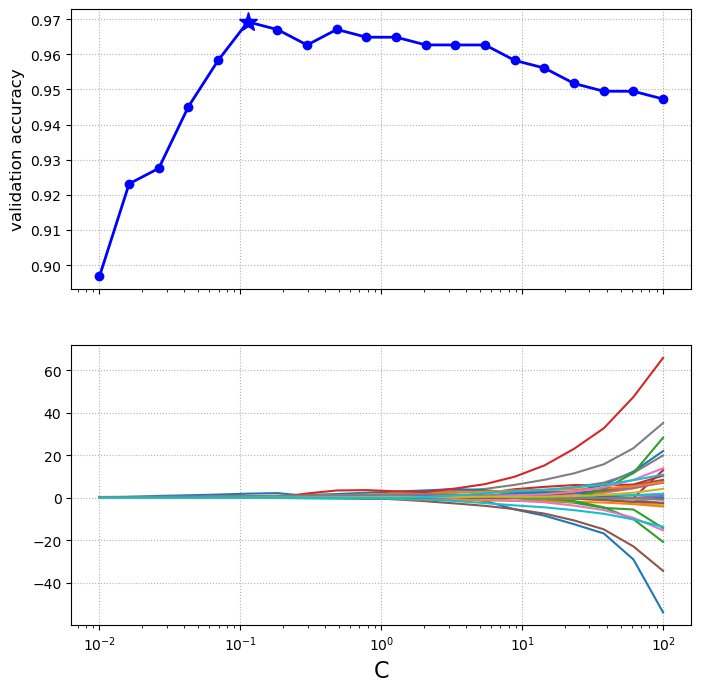

In [159]:
# 1. Set `cstar` to the index of the best performing regularization value
cstar = np.argmax(acc)

# 2. Set `acc_star` to the corresponding accuracy value
acc_star = acc[cstar]

print(cstar, acc_star)

# The next bit of code extracts the coefficients of the logistic regression for each of the 20 values of `C`. 
# This is stored in `theta` , which is a (20,30) array. (30 is the number of features)
theta = np.vstack([model.named_steps['logreg'].coef_[0,:] for model in models])

# 3. Plot the validation accuracy as a function of `C`. (done already)
fig, ax = plt.subplots(figsize=(8,8),nrows=2,sharex=True)
ax[0].semilogx(C,acc,'o-',color='b',linewidth=2)
ax[0].semilogx(C[cstar],acc_star,'*',color='b',markersize=14)
ax[0].grid(linestyle=':')
ax[0].set_ylabel('validation accuracy',fontsize=12)

# 4. In a single plot, plot the 30 coefficients as a fucntion of `C`.
ax[1].semilogx(C,theta)
ax[1].grid(linestyle=':')
ax[1].set_xlabel('C',fontsize=16)

In [160]:
grader.check("q9")

q9 results:
    q9 - 1 result:
        ❌ Test case failed
        Trying:
            cstar > 0 and acc_star > 0.9
        Expecting:
            np.True_
        **********************************************************************
        Line 1, in q9 0
        Failed example:
            cstar > 0 and acc_star > 0.9
        Expected:
            np.True_
        Got:
            True

    q9 - 2 result:
        ✅ Test case passed

# 10. Significant features

The plot below shows the coefficients for the best-case regularized logistic regression found in the previous part. Notice that many of these coefficients have been set to zero. 

<StemContainer object of 3 artists>

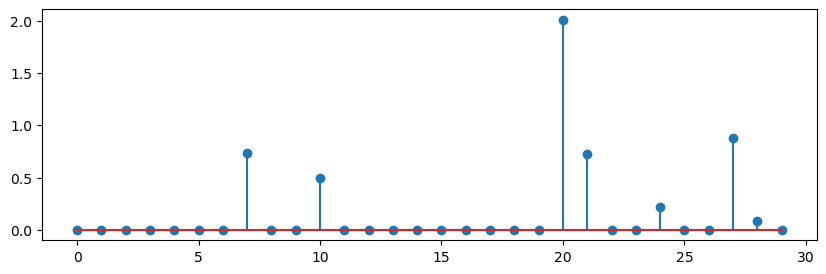

In [161]:
theta_star = theta[cstar,:]

plt.figure(figsize=(10,3))
plt.stem(np.abs(theta_star))

In [175]:
features = Xtrain.columns

non_zero_indices = np.where(np.abs(theta[cstar]) > 1e-5)[0]

best_features = features[non_zero_indices]
print(best_features)

max_theta_index = np.argmax(np.abs(theta_star))
max_theta_feature = features[max_theta_index]

lasso_model = models[cstar]

Index(['mean concave points', 'radius error', 'worst radius', 'worst texture',
       'worst smoothness', 'worst concave points', 'worst symmetry'],
      dtype='object')


In [176]:
grader.check("q10")

q10 results: All test cases passed!

# 11. Evaluate the final model with test data

Use the test dataset to evaluate the accuracy of the selected LASSO model. Use scikit-learn's [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) method to compute the test accuracy. 

In [177]:
from sklearn.metrics import accuracy_score

yhat = lasso_model.predict(Xtest)

lasso_test = accuracy_score(ytest, yhat)

In [178]:
grader.check("q11")

q11 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Make sure you submit the .zip file to Gradescope.

In [179]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)